In [1]:
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

import os
import numpy as np
import pandas as pd
import seaborn as sns
import random

from matplotlib import pyplot as plt
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sktime.transformations.series.paa import PAA
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

from scipy.spatial.distance import euclidean

from datetime import datetime
from collections import defaultdict

from sktime.transformations.compose import FitInTransform
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sktime.transformations.panel.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import sys

from sktime.distances import distance
from tslearn.metrics import dtw as tsldtw, dtw_path, cdist_dtw, subsequence_cost_matrix
from sklearn.metrics import pairwise_distances

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import LeaveOneOut

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold

from dtaidistance import dtw
import random

from sklearn.neighbors import sort_graph_by_row_values
import scipy.sparse as sp

from sklearn.model_selection import train_test_split, cross_val_score

In [2]:
import os
import numpy as np
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def load_npy(time_series):
    with open(time_series, 'rb') as f:
        return np.load(f)

def preparation_ts():
    dir_path = 'time_series/'
    len_threshold = 1280  # soglia entro la quale viene considerata la ts
    
    X, y, ids = [], [], []

    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1] != '.npy':
            continue

        split = file.split("_")  # suddivide il nome del file
        ids.append(split[0])  # track_id
        y.append(split[1][:-4])  # genre
        ts = load_npy(os.path.join(dir_path, file))
    
        if len(ts) > len_threshold:
            ts = ts[:len_threshold]
        else:
            pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
            ts = np.append(ts, pad)

        X.append([ts])

    X, y, ids = np.array(X), np.array(y), np.array(ids)
    
    # Ridimensiona X in base al numero effettivo di serie temporali caricate
    X = X.reshape((len(X), 1, len_threshold))
    
    return X, y, ids

# Preparare le serie temporali
X, y, ids = preparation_ts()

# Dividere il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicare MiniRocket per estrarre le caratteristiche
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
X_test_transform = minirocket.transform(X_test)

# Addestrare un classificatore sulle caratteristiche estratte
classifier = RandomForestClassifier()
classifier.fit(X_train_transform, y_train)

# Valutare il modello
y_pred = classifier.predict(X_test_transform)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.46


In [3]:
import os
import numpy as np
from sktime.transformations.panel.rocket import MiniRocket
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

def load_npy(time_series):
    with open(time_series, 'rb') as f:
        return np.load(f)

def preparation_ts():
    dir_path = 'time_series/'
    len_threshold = 1280  # soglia entro la quale viene considerata la ts
    
    X, y, ids = [], [], []

    for file in os.listdir(dir_path):
        if os.path.splitext(file)[1] != '.npy':
            continue

        split = file.split("_")  # suddivide il nome del file
        ids.append(split[0])  # track_id
        y.append(split[1][:-4])  # genre
        ts = load_npy(os.path.join(dir_path, file))
    
        if len(ts) > len_threshold:
            ts = ts[:len_threshold]
        else:
            pad = [ts[-1]] * (len_threshold - len(ts))  # fill with last observation
            ts = np.append(ts, pad)

        X.append([ts])

    X, y, ids = np.array(X), np.array(y), np.array(ids)
    
    # Ridimensiona X in base al numero effettivo di serie temporali caricate
    X = X.reshape((len(X), 1, len_threshold))
    
    return X, y, ids

# Preparare le serie temporali
X, y, ids = preparation_ts()

# Normalizzazione delle serie temporali
scaler = StandardScaler()
X_reshaped = X.reshape(X.shape[0], -1)  # Risagomare per scalare
X_scaled = scaler.fit_transform(X_reshaped)
X = X_scaled.reshape(X.shape[0], 1, X.shape[2])  # Ritornare alla forma originale

# Dividere il dataset in train e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Applicare MiniRocket per estrarre le caratteristiche
minirocket = MiniRocket()
minirocket.fit(X_train)
X_train_transform = minirocket.transform(X_train)
X_test_transform = minirocket.transform(X_test)

# Addestrare un classificatore con ottimizzazione dei parametri
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None]
}

classifier = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_transform, y_train)

# Valutare il modello
best_classifier = grid_search.best_estimator_
y_pred = best_classifier.predict(X_test_transform)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Best parameters: {grid_search.best_params_}')


Fitting 3 folds for each of 9 candidates, totalling 27 fits
Accuracy: 0.46
Best parameters: {'max_depth': None, 'n_estimators': 300}


Accuracy: 0.46
Best parameters: {'max_depth': None, 'n_estimators': 300}


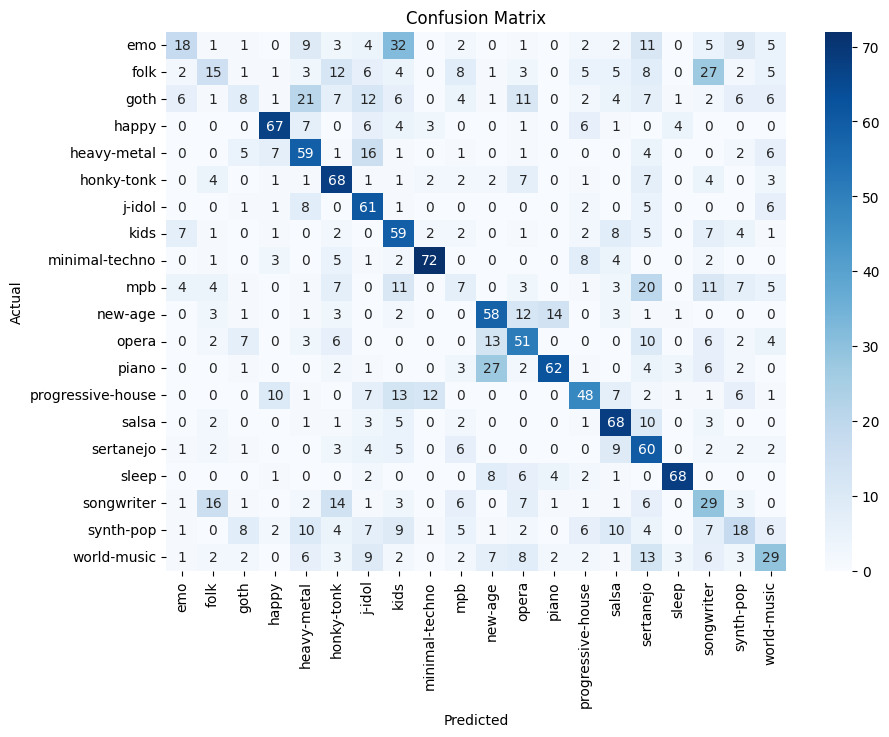

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Valutare il modello
y_pred = best_classifier.predict(X_test_transform)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(f'Best parameters: {grid_search.best_params_}')

# Matrice di confusione
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualizzare la matrice di confusione
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [6]:
y_prob = best_classifier.predict_proba(X_test_transform)


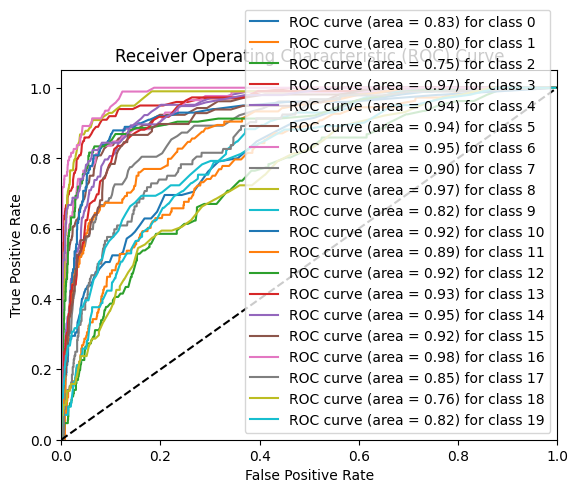

In [7]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarizza le etichette di test per gestire la classificazione multi-classe
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_binarized.shape[1]

# Calcola FPR, TPR e AUC per ogni classe
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Traccia la curva ROC per ogni classe
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()
